<a href="https://colab.research.google.com/github/rajagurunath/PowerGenForecast/blob/master/powerGenForecastv4_datasetA_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls

Dataset_A.xlsx				model-ep012-loss0.332-val_loss2.192.h5
last_day.csv				model-ep013-loss0.275-val_loss2.208.h5
logs2					model-ep014-loss0.258-val_loss1.289.h5
model-ep001-loss0.612-val_loss0.640.h5	model-ep015-loss0.170-val_loss1.323.h5
model-ep002-loss0.461-val_loss0.585.h5	model-ep016-loss0.276-val_loss1.726.h5
model-ep003-loss0.369-val_loss1.858.h5	model-ep017-loss0.383-val_loss2.134.h5
model-ep004-loss0.266-val_loss4.768.h5	model-ep018-loss0.563-val_loss2.384.h5
model-ep005-loss0.276-val_loss2.761.h5	model-ep019-loss0.240-val_loss2.116.h5
model-ep006-loss0.157-val_loss1.945.h5	model-ep020-loss0.226-val_loss1.186.h5
model-ep007-loss0.068-val_loss1.895.h5	model-ep021-loss0.233-val_loss0.964.h5
model-ep008-loss0.295-val_loss5.275.h5	model-ep022-loss0.203-val_loss0.779.h5
model-ep009-loss0.345-val_loss2.910.h5	ngrok
model-ep010-loss0.109-val_loss1.487.h5	ngrok-stable-linux-amd64.zip
model-ep011-loss0.299-val_loss1.452.h5	sample_data


In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
#import path
import sys

In [0]:
plt.style.use('seaborn-notebook')

In [4]:
tf.__version__,pd.__version__

('1.13.1', '0.24.2')

In [5]:
from google.colab import files
uploaded = files.upload()


Saving Dataset_A.xlsx to Dataset_A (1).xlsx


In [0]:
import io
filename='Dataset_A.xlsx'
electric_df=pd.read_excel(io.BytesIO(uploaded[filename]))


In [0]:
#DATA_DIR='https://github.com/rajagurunath/PowerGenForecast/blob/master/data/Dataset_A.xlsx?raw=true'
#electric_df=pd.read_excel(DATA_DIR)

In [8]:
electric_df.head()

,Timestamp,Actual_Power Generation [kW],Wind Speed [m/s]
0,2017-09-02 00:00:00,0.0,5.31959
1,2017-09-02 00:15:00,6966.0,4.84861
2,2017-09-02 00:30:00,4356.0,4.37764
3,2017-09-02 00:45:00,14310.0,4.36338
4,2017-09-02 01:00:00,16380.0,4.34912


In [9]:
electric_df.columns

Index(['Timestamp', 'Actual_Power Generation [kW]', 'Wind Speed [m/s]'], dtype='object')

In [0]:
datetime_col='Timestamp'
power_col='Actual_Power Generation [kW]'
windspeed_col='Wind Speed [m/s]'

In [0]:
electric_df.set_index(pd.to_datetime(electric_df[datetime_col]),inplace=True)

In [12]:
electric_df.iloc[:,:].isna().sum()

Timestamp                          0
Actual_Power Generation [kW]    2152
Wind Speed [m/s]                5568
dtype: int64

In [0]:
electric_df=electric_df.fillna(electric_df.mean())

## Ploting

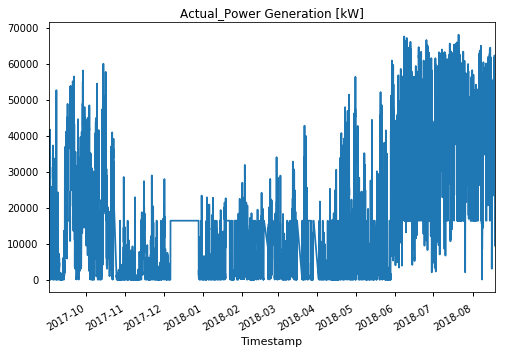

In [14]:
electric_df[power_col].plot(title=power_col)
plt.show()

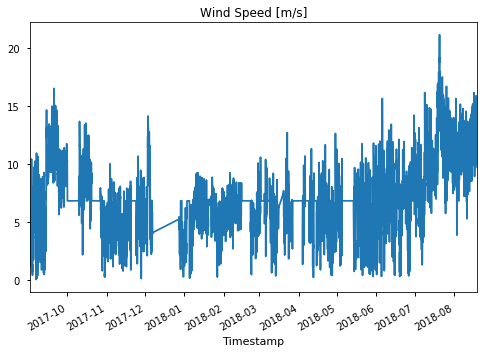

In [15]:
electric_df[windspeed_col].plot(title=windspeed_col)
plt.show()

# Monthwise

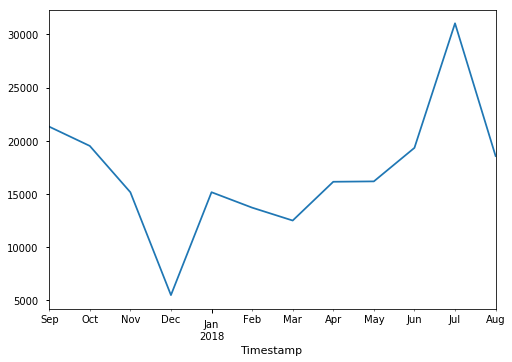

In [16]:
electric_df.resample('1m').sum()[windspeed_col].plot()

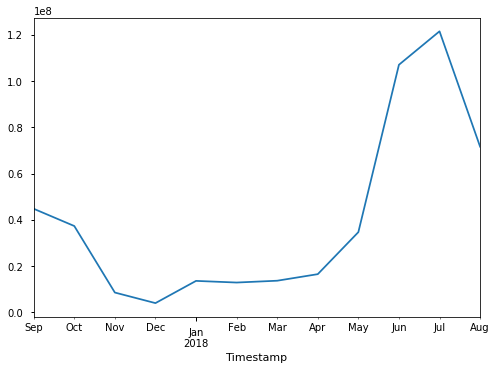

In [17]:
electric_df.resample('1m').sum()[power_col].plot()

# Weekly

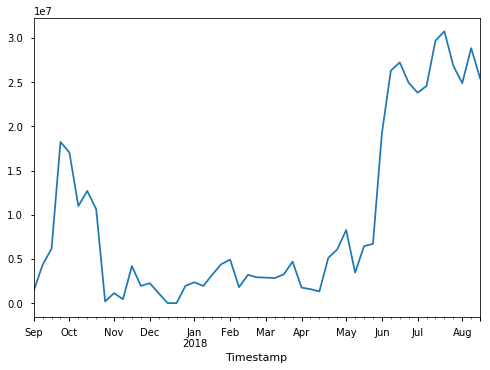

In [18]:
electric_df.resample('1w').sum()[power_col].plot()

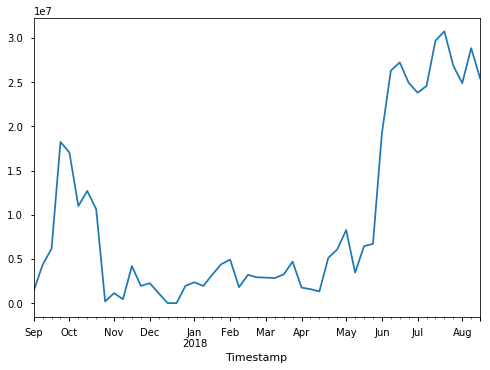

In [19]:
electric_df.resample('1w').sum()[power_col].plot()

# Daywise

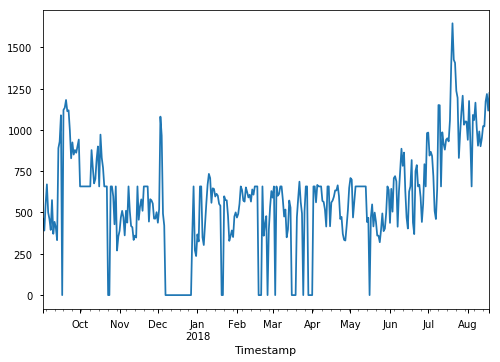

In [20]:
electric_df.resample('1D').sum()[windspeed_col].plot()

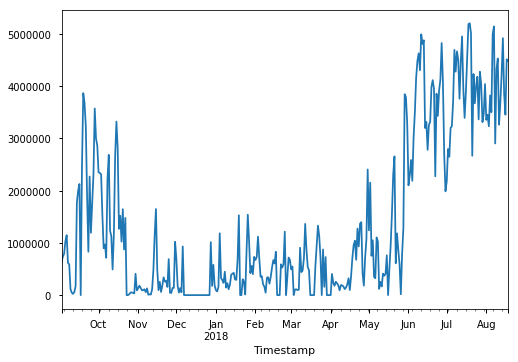

In [21]:
electric_df.resample('1D').sum()[power_col].plot()

# Train -test Split

In [22]:
electric_df[power_col].values.reshape(1,-1)

array([[    0.,  6966.,  4356., ..., 46035., 38484., 41904.]])

In [0]:
from sklearn.preprocessing import StandardScaler,Normalizer
scalar=StandardScaler()
scaled=scalar.fit_transform(electric_df[[windspeed_col,power_col]].values)

electric_df['PowerGenScaled']=scaled[:,0]
electric_df['WindSpeedScaled']=scaled[:,1]

In [0]:
electric_df=electric_df.sort_index()

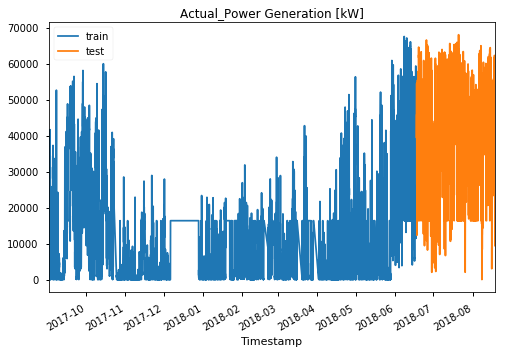

In [25]:
train=electric_df[:int(len(electric_df)*0.8)]
test=electric_df[int(len(electric_df)*0.8):]
train[power_col].plot(label='train')
test[power_col].plot(label='test')
plt.title(power_col)
plt.legend()
plt.show()

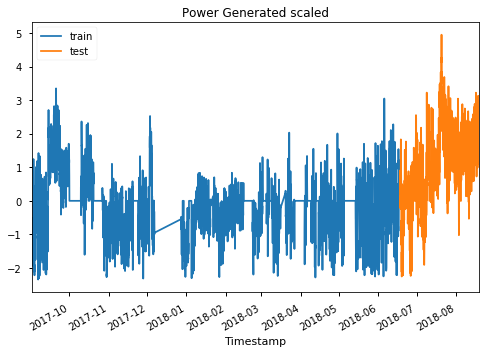

In [26]:
train['PowerGenScaled'].plot(label='train')
test['PowerGenScaled'].plot(label='test')
plt.title('Power Generated scaled')
plt.legend()
plt.show()

# Neural Networks-Model Building

## Approach 1 -Treating power Generated as Sequence

In [0]:
#@title Train config
INP_SEQ = 96 #@param {type:raw}'

OUT_SEQ=96 #@param {type:raw}'

In [0]:
power=train['PowerGenScaled'].values
wind=train['WindSpeedScaled'].values

def powerG():
    inp_l=[]
    out_l=[]
    for i in range(power.shape[0]-(OUT_SEQ)):
        yield (wind[i:i+INP_SEQ].reshape(1,-1),power[i:i+OUT_SEQ].reshape(1,-1))
        
def prepare_data(W,P):
    print(W.shape)
    inp_l=[]
    out_l=[]
    for i in range(W.shape[0]-(OUT_SEQ)):
        inp_l.append(W[i:i+INP_SEQ])
        out_l.append(P[i:i+OUT_SEQ])
    X=np.array(inp_l)
    Y=np.array(out_l)
    return X,Y

In [29]:
X,Y=prepare_data(wind,power)

(23808,)


ludwigdf=pd.DataFrame({'inp_ts':[X],'out_ts':[Y]},index=range(len(X)))
ludwigdf.to_csv(DIR+'/ludwig_ts.csv')

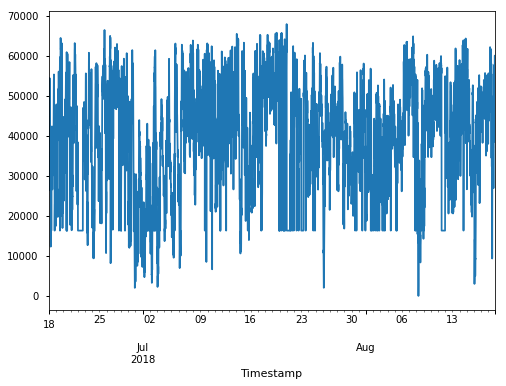

In [30]:
test[power_col][test[power_col].isna()]
test[power_col].plot()

In [0]:
arraytest=test['PowerGenScaled'].values
powertest=test['PowerGenScaled'].values
windtest=test['WindSpeedScaled'].values


def powerGtest(use_as_iter=True):
    if use_as_iter:
        for i in range(powertest.shape[0]-(OUT_SEQ)):
            yield (windtest[i:i+INP_SEQ].reshape(1,-1),powertest[i:i+OUT_SEQ].reshape(1,-1))
def inference():
    inp_l=[]
    out_l=[]
    for i in range(powertest.shape[0]-(OUT_SEQ)):
        inp_l.append(windtest[i:i+INP_SEQ])
        out_l.append(powertest[i:i+OUT_SEQ])
    X=np.array(inp_l)
    Y=np.array(out_l)
    return X,Y
#xt,yt=powerGtest()

In [32]:
dstest=tf.data.Dataset.from_generator(powerGtest,(tf.float32,tf.float32),(tf.TensorShape([1,96]),tf.TensorShape([1,96])))

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [0]:
ds=tf.data.Dataset.from_generator(powerG,(tf.float32,tf.float32),(tf.TensorShape([1,96]),tf.TensorShape([1,96])))

In [0]:
value=ds.make_one_shot_iterator().get_next()

In [35]:
sess=tf.Session()
sess.run(value)

(array([[-8.95475626e-01, -5.13800800e-01, -6.56805575e-01,
         -1.11415014e-01,  2.00255564e-03, -5.15773296e-01,
         -3.57974946e-01, -1.28181085e-01, -3.49098802e-01,
         -5.69030225e-01, -6.80475354e-01, -5.53250432e-01,
         -6.84420288e-01, -7.75154352e-01, -7.80085564e-01,
         -8.27671587e-01, -8.46163630e-01, -8.78709495e-01,
         -8.94489348e-01, -8.95475626e-01, -8.95475626e-01,
         -8.95475626e-01, -8.94489348e-01, -8.80681992e-01,
         -8.94489348e-01, -8.95475626e-01, -8.95475626e-01,
         -8.95475626e-01, -8.95475626e-01, -8.95475626e-01,
         -8.95475626e-01, -8.95475626e-01, -8.95475626e-01,
         -8.95475626e-01, -8.95475626e-01, -8.95475626e-01,
         -8.95475626e-01, -8.95475626e-01, -8.95475626e-01,
         -8.95475626e-01, -8.95475626e-01, -8.95475626e-01,
         -8.95475626e-01, -8.95475626e-01, -8.95475626e-01,
         -8.95475626e-01, -8.95475626e-01, -8.95475626e-01,
         -8.95475626e-01, -8.95475626e-0

In [0]:
class windToPower(tf.keras.Model):
    def __init__(self, outseq,num_units=192,batch_size=1):
        super().__init__()
        self.outseq = outseq
        self.batch_size=batch_size
        self.cell = tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell',num_units=num_units)
        self.dense = tf.keras.layers.Dense(units=self.outseq)

    def call(self, inputs):
        state = self.cell.zero_state(batch_size=self.batch_size, dtype=tf.float32)
        output,state=self.cell(inputs,state)
        output=self.dense(output)
        return output

In [37]:
lstm=windToPower(num_units=INP_SEQ,outseq=OUT_SEQ)
lstm.compile('adam',loss='mse')

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.


In [40]:
TB=tf.keras.callbacks.TensorBoard('./logs2',histogram_freq=10,write_grads=True,batch_size=32,write_graph=True)
ES=tf.keras.callbacks.EarlyStopping(patience=20)
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

MC=tf.keras.callbacks.ModelCheckpoint(filepath,save_weights_only=True)
#lstm.load_weights('./lstm2.h5')
history=lstm.fit(ds,epochs=50,steps_per_epoch=500,validation_data=dstest,validation_steps=10,callbacks=[ES,MC,TB])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
500/500 [==============================] - 1s 3ms/step - loss: 0.6159 - val_loss: 0.5318
Epoch 2/50
500/500 [==============================] - 1s 2ms/step - loss: 0.4561 - val_loss: 0.5337
Epoch 3/50
500/500 [==============================] - 1s 2ms/step - loss: 0.3815 - val_loss: 2.9534
Epoch 4/50
500/500 [==============================] - 1s 2ms/step - loss: 0.2658 - val_loss: 8.8810
Epoch 5/50
500/500 [==============================] - 1s 2ms/step - loss: 0.2820 - val_loss: 3.5132
Epoch 6/50
500/500 [==============================] - 1s 2ms/step - loss: 0.1827 - val_loss: 2.1641
Epoch 7/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0513 - val_loss: 1.8983
Epoch 8/50
500/500 [==============================] - 1s 2ms/step - loss: 0.2905 - val_loss: 3.8833
Epoch 9/50
500/500 [==============================] - 1s 2ms/step - loss: 0.3676 - val_loss: 2.2144
Epoc

In [41]:
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
basic_lstm_cell (LSTMCell)   multiple                  74112     
_________________________________________________________________
dense (Dense)                multiple                  9312      
Total params: 83,424
Trainable params: 83,424
Non-trainable params: 0
_________________________________________________________________


In [42]:
!ls

'Dataset_A (1).xlsx'
 Dataset_A.xlsx
 last_day.csv
 logs2
 model-ep001-loss0.612-val_loss0.640.h5
 model-ep001-loss0.616-val_loss0.532.h5
 model-ep002-loss0.456-val_loss0.534.h5
 model-ep002-loss0.461-val_loss0.585.h5
 model-ep003-loss0.369-val_loss1.858.h5
 model-ep003-loss0.381-val_loss2.953.h5
 model-ep004-loss0.266-val_loss4.768.h5
 model-ep004-loss0.266-val_loss8.881.h5
 model-ep005-loss0.276-val_loss2.761.h5
 model-ep005-loss0.282-val_loss3.513.h5
 model-ep006-loss0.157-val_loss1.945.h5
 model-ep006-loss0.183-val_loss2.164.h5
 model-ep007-loss0.051-val_loss1.898.h5
 model-ep007-loss0.068-val_loss1.895.h5
 model-ep008-loss0.291-val_loss3.883.h5
 model-ep008-loss0.295-val_loss5.275.h5
 model-ep009-loss0.345-val_loss2.910.h5
 model-ep009-loss0.368-val_loss2.214.h5
 model-ep010-loss0.097-val_loss1.432.h5
 model-ep010-loss0.109-val_loss1.487.h5
 model-ep011-loss0.299-val_loss1.452.h5
 model-ep011-loss0.376-val_loss1.511.h5
 model-ep012-loss0.324-val_loss1.994.h5
 model-ep012-loss0.332

# Tensorboard visualization

In [43]:
LOG_DIR = 'logs2'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip


--2019-05-05 12:22:56--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.72.245.79, 52.207.111.186, 52.4.95.48, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.72.245.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14991793 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  14.30M  17.8MB/s    in 0.8s    

2019-05-05 12:22:57 (17.8 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [14991793/14991793]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: ngrok                   


***Tensorboard link ***

In [44]:
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


https://fed59b01.ngrok.io


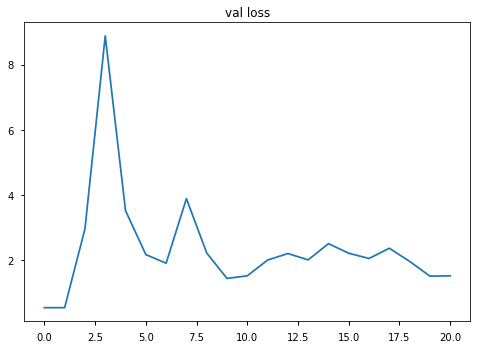

In [45]:
plt.plot(lstm.history.history['val_loss'])
plt.title('val loss')
plt.show()

In [46]:
lstm.evaluate(dstest,steps=100)

100/100 [==============================] - 0s 1ms/step - loss: 1.6358


1.6358293050527573

In [0]:
predicted=lstm.predict(dstest,steps=1)

In [48]:
predicted.shape

(1, 96)

# inference or prediction time

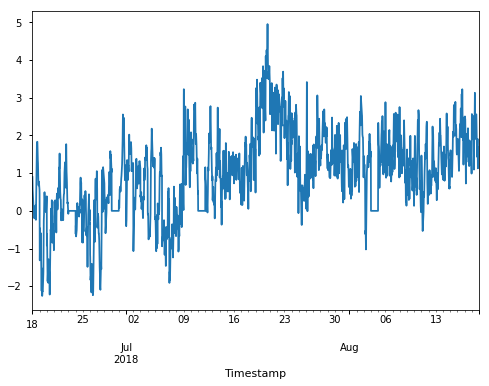

In [49]:
test['PowerGenScaled'].plot()

In [0]:
predicted=lstm.predict_on_batch(dstest)

In [0]:
testiter=dstest.make_one_shot_iterator()
x,y=testiter.get_next()

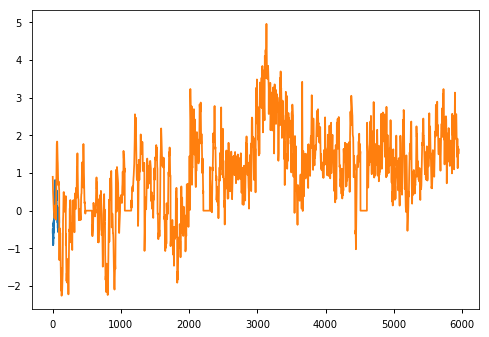

In [52]:
plt.plot(predicted.reshape(-1))
plt.plot(test['PowerGenScaled'].values)
plt.show()

In [0]:
xtest,ytest=inference()
#lstm.predict(X)

In [54]:
xtest.shape,ytest.shape,xtest[0].reshape(1,-1).shape

((5856, 96), (5856, 96), (1, 96))

# *Prediction for last 10 days*

In [0]:
from sklearn.metrics import mean_absolute_error,mean_squared_error


In [56]:
predicted.shape,xtest.shape,predicted.shape,xtest[1].shape
#scalar.inverse_transform([xtest[ithday],predicted[ithday-1]])

((1, 96), (5856, 96), (1, 96), (96,))

In [57]:

scalar.inverse_transform(np.array([xtest[1],predicted.reshape(-1)]).reshape(96,-1))

array([[ 1.10021551e+01,  4.67640000e+04],
       [ 1.13551051e+01,  4.24440000e+04],
       [ 1.04898082e+01,  4.83840000e+04],
       [ 1.28864528e+01,  5.32080000e+04],
       [ 1.15187714e+01,  4.06800000e+04],
       [ 1.03930316e+01,  3.63240000e+04],
       [ 9.33275835e+00,  3.40920000e+04],
       [ 8.92430408e+00,  2.63880000e+04],
       [ 8.90153311e+00,  3.28680000e+04],
       [ 9.92053400e+00,  3.48480000e+04],
       [ 7.39295636e+00,  1.23300000e+04],
       [ 7.14816844e+00,  1.71720000e+04],
       [ 7.73452091e+00,  2.92230000e+04],
       [ 9.20324846e+00,  3.66840000e+04],
       [ 1.01406534e+01,  1.63434511e+04],
       [ 9.80667915e+00,  4.14900000e+04],
       [ 1.01596292e+01,  3.71160000e+04],
       [ 9.82375738e+00,  3.39480000e+04],
       [ 1.05922776e+01,  4.24080000e+04],
       [ 1.06435123e+01,  3.72600000e+04],
       [ 1.04613445e+01,  3.32640000e+04],
       [ 8.62970466e+00,  2.66400000e+04],
       [ 9.26017588e+00,  3.36780000e+04],
       [ 9.

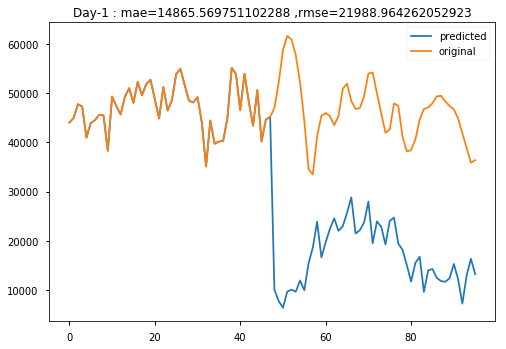

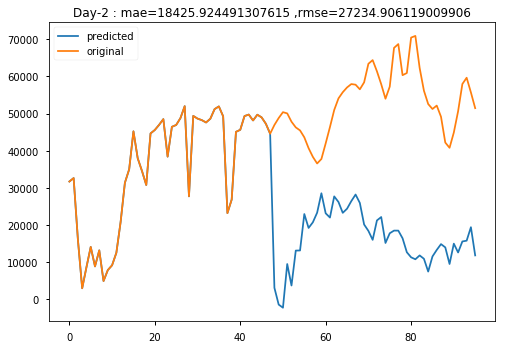

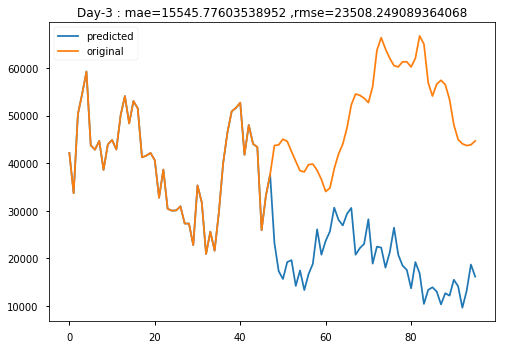

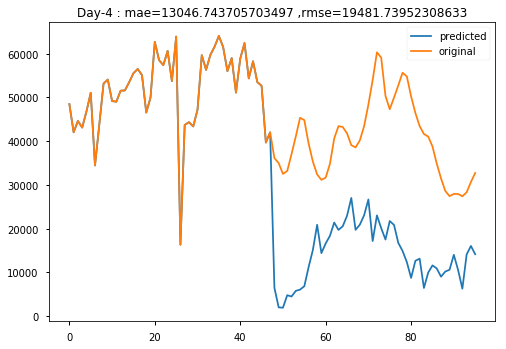

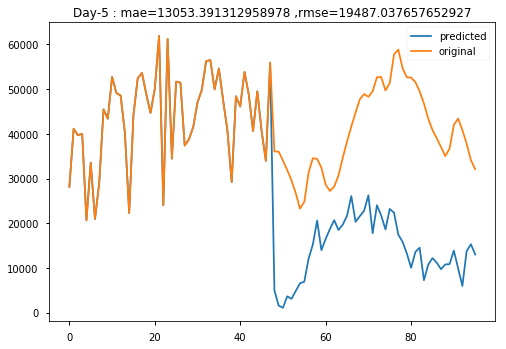

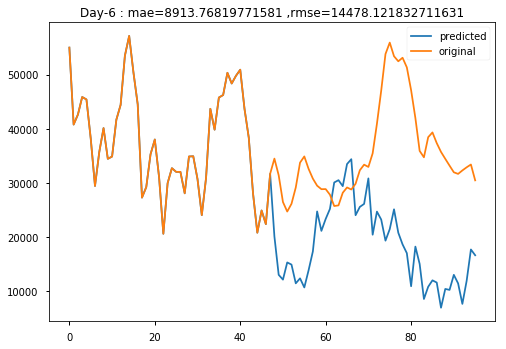

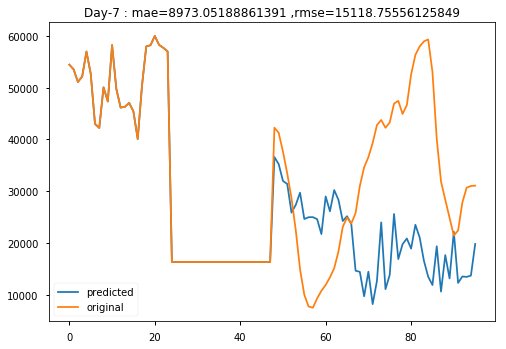

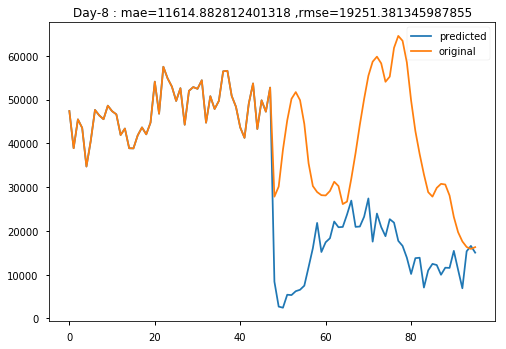

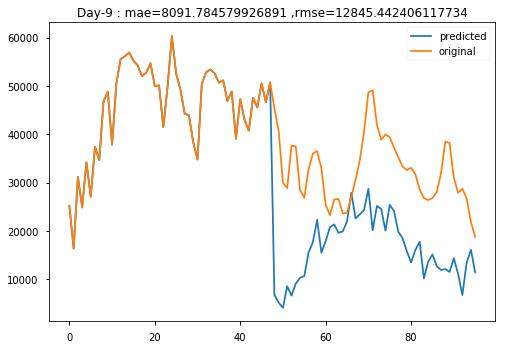

In [58]:
for i in range(1,10):
  ithday=len(xtest)-96*i
  predicted=lstm.predict(xtest[ithday].reshape(1,-1))
  original=ytest[ithday]
  
  original=scalar.inverse_transform(np.array([xtest[ithday],original.reshape(-1)]).reshape(OUT_SEQ,-1))[:,1]
  predicted=scalar.inverse_transform(np.array([xtest[ithday],predicted.reshape(-1)]).reshape(OUT_SEQ,-1))[:,1]
  
  plt.plot(predicted.reshape(-1),label='predicted')
  plt.plot(original,label='original')
  mae=mean_absolute_error(original,predicted.reshape(-1))
  rmse=mean_squared_error(original,predicted.reshape(-1))**0.5
  plt.title('Day-{} : mae={} ,rmse={}'.format(i,mae,rmse))
  plt.legend()
  plt.show()

In [59]:
lstm_est=tf.keras.estimator.model_to_estimator(lstm)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp2rhz7pc1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb217eb1198>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replica

# prediction for the next day

lstmestimator=tf.keras.estimator.model_to_estimator(keras_model=lstm)

In [60]:
last_day=electric_df[datetime_col].max().date()
print(last_day)
electric_df[electric_df[datetime_col]>=last_day]

2018-08-18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  This is separate from the ipykernel package so we can avoid doing imports until


,Timestamp,Actual_Power Generation [kW],Wind Speed [m/s],PowerGenScaled,WindSpeedScaled
Timestamp,,,,,
2018-08-18 00:00:00,2018-08-18 00:00:00,48708.0,12.9448,2.111075,1.773289
2018-08-18 00:15:00,2018-08-18 00:15:00,54324.0,13.6045,2.339655,2.080996
2018-08-18 00:30:00,2018-08-18 00:30:00,55692.0,14.2642,2.568234,2.155950
2018-08-18 00:45:00,2018-08-18 00:45:00,54864.0,14.0538,2.495333,2.110583
2018-08-18 01:00:00,2018-08-18 01:00:00,50436.0,13.8434,2.422431,1.867968
2018-08-18 01:15:00,2018-08-18 01:15:00,51228.0,13.6329,2.349495,1.911363
2018-08-18 01:30:00,2018-08-18 01:30:00,44874.0,13.4225,2.276593,1.563220
2018-08-18 01:45:00,2018-08-18 01:45:00,43830.0,13.2182,2.205805,1.506018
2018-08-18 02:00:00,2018-08-18 02:00:00,46350.0,13.0140,2.135052,1.644092


In [61]:
electric_df[electric_df[datetime_col]>=last_day].to_csv('last_day.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


In [0]:
last_day_df=pd.read_csv('last_day.csv')

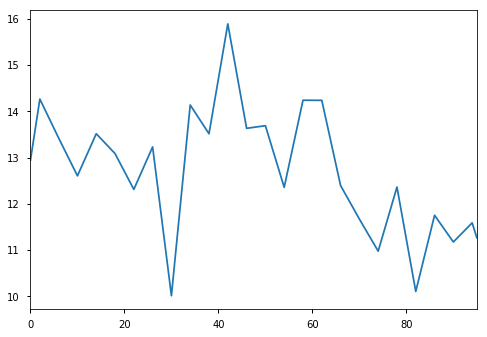

In [63]:
last_day_df[windspeed_col].plot()

In [64]:
power_col

'Actual_Power Generation [kW]'

In [65]:
last_day_values=np.array([last_day_df[windspeed_col].values,
         lstm.predict(last_day_df[windspeed_col].values.reshape(1,-1)).reshape(-1)]).reshape(OUT_SEQ,-1)
scalar.inverse_transform(last_day_values)

array([[4.42118460e+01, 2.64641094e+05],
       [4.80197459e+01, 2.72841331e+05],
       [4.68052815e+01, 2.65159426e+05],
       [4.55905285e+01, 2.57590678e+05],
       [4.44115630e+01, 2.50135087e+05],
       [4.32325975e+01, 2.50560339e+05],
       [4.45460545e+01, 2.58866433e+05],
       [4.58595116e+01, 2.61062045e+05],
       [4.52401579e+01, 2.57143525e+05],
       [4.46205155e+01, 2.51653582e+05],
       [4.35036008e+01, 2.44590391e+05],
       [4.23866861e+01, 2.45247432e+05],
       [4.37111103e+01, 2.53622880e+05],
       [4.50358231e+01, 2.43139425e+05],
       [4.03952878e+01, 2.13791591e+05],
       [3.57547525e+01, 2.17927299e+05],
       [4.17029727e+01, 2.55544725e+05],
       [4.76514815e+01, 2.71512648e+05],
       [4.67533320e+01, 2.65834718e+05],
       [4.58554711e+01, 2.73830543e+05],
       [4.92824078e+01, 2.95500122e+05],
       [5.27090560e+01, 2.96038531e+05],
       [4.94523982e+01, 2.75443944e+05],
       [4.61954518e+01, 2.65405817e+05],
       [4.627799

In [66]:
last_day_predicted=scalar.inverse_transform(np.array([last_day_df['WindSpeedScaled'].values,
         lstm.predict(last_day_df['WindSpeedScaled'].values.reshape(1,-1)).reshape(-1)]).reshape(OUT_SEQ,-1))[:,1]
last_day_predicted.shape

(96,)

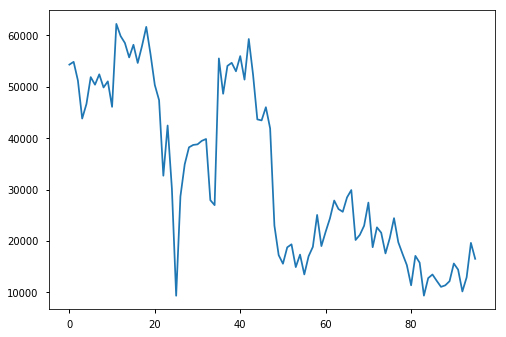

In [67]:
plt.plot(last_day_predicted)
plt.show()

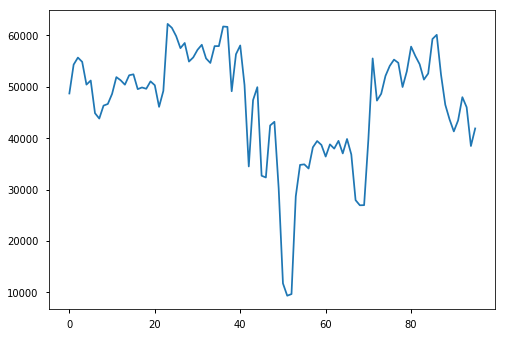

In [68]:
last_day_power_generated=last_day_df[power_col]
plt.plot(last_day_power_generated)
plt.show()

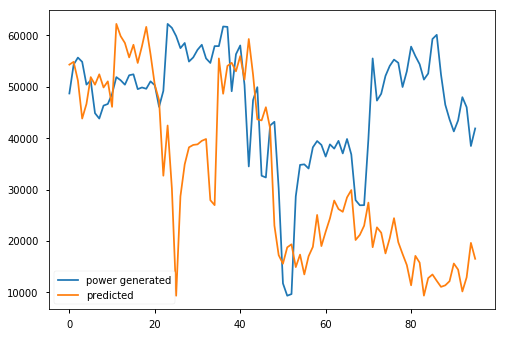

In [69]:
plt.plot(last_day_power_generated,label='power generated')
plt.plot(last_day_predicted,label='predicted')
plt.legend()
plt.show()

In [0]:
last_day_df['predicted_power']=last_day_predicted
last_day_df.to_csv('last_day.csv')

In [0]:
file_to_download='last_day.csv'
files.download(file_to_download)